In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyrsm as rsm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

ImportError: cannot import name 'Tags' from 'sklearn.utils' (/opt/conda/lib/python3.11/site-packages/sklearn/utils/__init__.py)

In [41]:
! pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 4.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1


In [ ]:
data = pd.read_csv(r'../data/historical_data.csv')
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


## EDA

In [11]:
# Quick overview
print("Shape:", data.shape)
print("\nColumns:")
print(data.columns.tolist())


Shape: (197428, 17)

Columns:
['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'target']


In [12]:
print("\nData types:")
print(data.dtypes)


Data types:
market_id                                              float64
created_at                                      datetime64[ns]
actual_delivery_time                            datetime64[ns]
store_id                                                 int64
store_primary_category                                  object
order_protocol                                         float64
total_items                                              int64
subtotal                                                 int64
num_distinct_items                                       int64
min_item_price                                           int64
max_item_price                                           int64
total_onshift_dashers                                  float64
total_busy_dashers                                     float64
total_outstanding_orders                               float64
estimated_order_place_duration                           int64
estimated_store_to_consumer_driving_durati

In [13]:
print("\nMissing values:")
print(data.isna().sum())


Missing values:
market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              7
dtype: int64


In [15]:
categorical_cols = data.select_dtypes(include=["object"]).columns
print("\nCategorical columns:")
for col in categorical_cols:
    print(f"{col}: {data[col].nunique()} unique values")


Categorical columns:
store_primary_category: 74 unique values


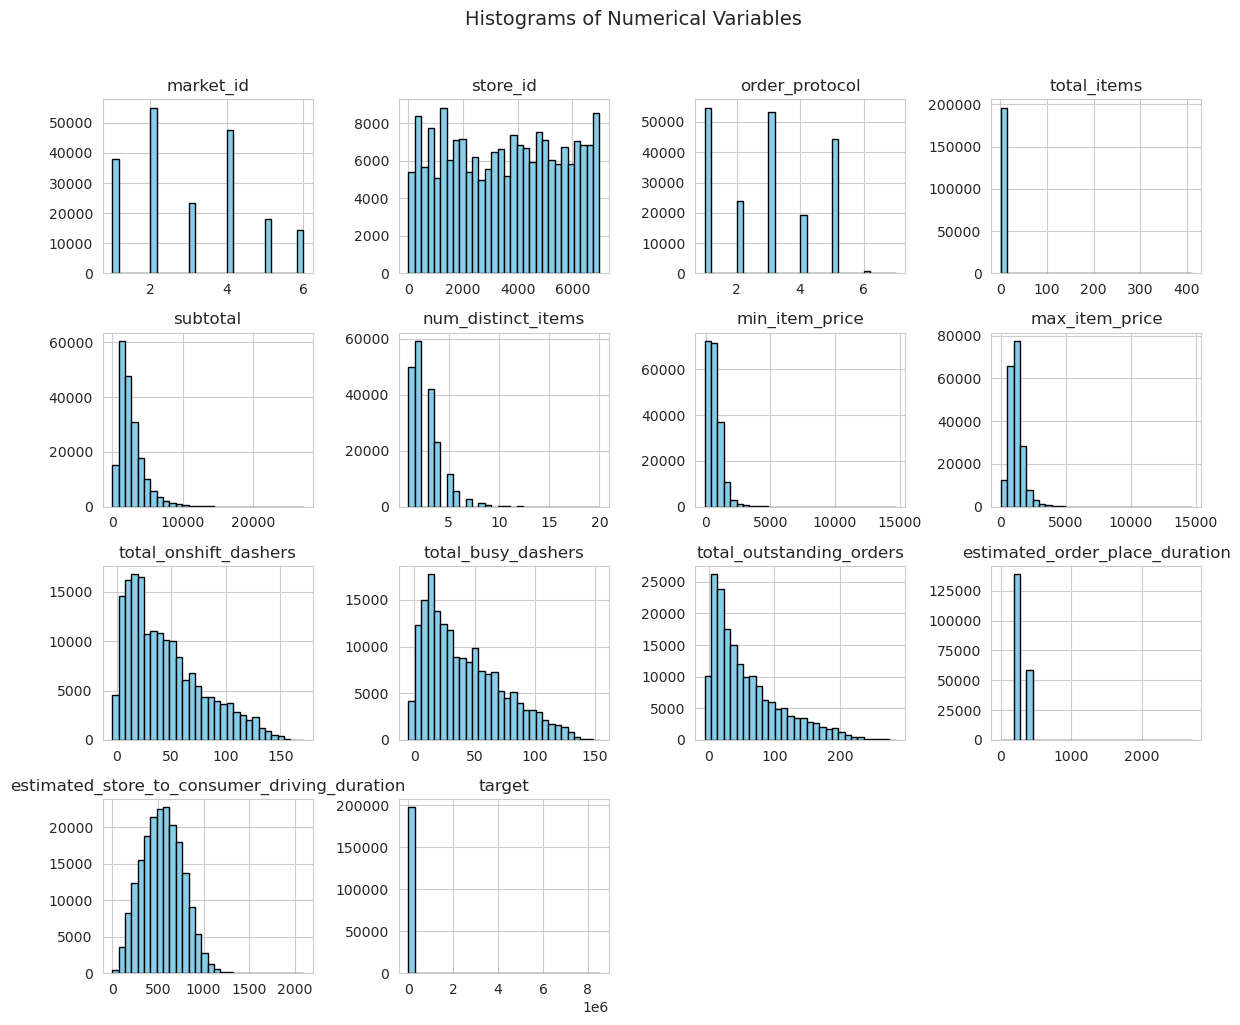

In [25]:
# Histograms for numerical variables
sns.set_style("whitegrid")

numeric_cols = data.select_dtypes(include=['number'])

numeric_cols.hist(
    figsize=(12, 10),
    bins=30,             
    edgecolor='black',    
    color='skyblue'    
)

plt.suptitle("Histograms of Numerical Variables", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Create target value column 

In [33]:
# calculate deliver duration

data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['created_at'] = pd.to_datetime(data['created_at'])
data['target'] =  (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()
data['target']

0         3779.0
1         4024.0
2         1781.0
3         3075.0
4         2390.0
           ...  
197423    3907.0
197424    3383.0
197425    3008.0
197426    3907.0
197427    2228.0
Name: target, Length: 197421, dtype: float64

## Data Cleaning

In [26]:
# remove rows with missing target value
data = data.dropna(subset=['actual_delivery_time', 'created_at'])
print(data.isna().sum())

market_id                                         987
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


In [27]:
# market_id: Missing values are filled using the next row's value.
# This approach assumes that nearby rows in the dataset typically belong to the same market,
# so forward/backward filling is a reasonable approximation.

data['market_id'] = data['market_id'].fillna(method='bfill')  # or 'ffill' depending on data pattern
print(data.isna().sum())

market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


/tmp/ipykernel_111465/306552265.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['market_id'] = data['market_id'].fillna(method='bfill')  # or 'ffill' depending on data pattern


In [29]:
# store_primary_category: Missing values are replaced with "Other".
# The distribution shows high category diversity and low missing rate (2%),
# so we fill with "Other"
data['store_primary_category'] = data['store_primary_category'].fillna('Other')
print(data.isna().sum())


market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                              0
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


In [30]:
# order_protocol: Missing values are filled using the next row's value (backward fill).
# Since nearby rows in the dataset often belong to the same store or market context,
# so we assume they share a similar order protocol.
data['order_protocol'] = data['order_protocol'].fillna(method='bfill')
print(data.isna().sum())

market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                              0
order_protocol                                      0
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
target                                              0
dtype: int64


/tmp/ipykernel_111465/1599200043.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['order_protocol'] = data['order_protocol'].fillna(method='bfill')


In [31]:
#Filling Missing Values for Marketplace Features
# Since they are count-based and right-skewed, missing values are filled with each column’s **median**, which is more robust to outliers than the mean.
for col in ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']: 
    data[col] = data[col].fillna(data[col].median())

print(data.isna().sum())

market_id                                         0
created_at                                        0
actual_delivery_time                              0
store_id                                          0
store_primary_category                            0
order_protocol                                    0
total_items                                       0
subtotal                                          0
num_distinct_items                                0
min_item_price                                    0
max_item_price                                    0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_order_place_duration                    0
estimated_store_to_consumer_driving_duration    526
target                                            0
dtype: int64


In [32]:
# estimated_store_to_consumer_driving_duration:
# Missing values are filled with the median, as the feature is continuous and right-skewed.
# Median imputation helps reduce the impact of outliers.

data['estimated_store_to_consumer_driving_duration'] = (
    data['estimated_store_to_consumer_driving_duration']
    .fillna(data['estimated_store_to_consumer_driving_duration'].median())
)
print(data.isna().sum())
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")


market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
target                                          0
dtype: int64
The dataset has 197421 rows and 17 columns.


In [35]:
# Remove the outlier in the target col

data = data[data['target'] <= 8_000_000]

print(f"Data shape after removing large outliers: {data.shape}")


Data shape after removing large outliers: (197420, 17)


## Split training/testing dataset

In [37]:
X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Encoding for Categorical cols

In [39]:
# Onehot encoding: market_id, order_protocol
# These two features have a small number of categories (6 and 7),
# so one-hot encoding is appropriate.
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit on training data only
encoder.fit(X_train[['market_id', 'order_protocol']])

# Transform train and test sets
train_encoded = encoder.transform(X_train[['market_id', 'order_protocol']])
test_encoded = encoder.transform(X_test[['market_id', 'order_protocol']])

# Convert to DataFrame
train_encoded_df = pd.DataFrame(train_encoded, 
                                columns=encoder.get_feature_names_out(['market_id', 'order_protocol']),
                                index=X_train.index)
test_encoded_df = pd.DataFrame(test_encoded, 
                               columns=encoder.get_feature_names_out(['market_id', 'order_protocol']),
                               index=X_test.index)

# Concatenate encoded features and drop original columns
X_train = pd.concat([X_train.drop(['market_id', 'order_protocol'], axis=1), train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(['market_id', 'order_protocol'], axis=1), test_encoded_df], axis=1)

In [ ]:
# Target encoding for high-cardinality categorical features:
# - store_id (~6,743 distinct)
# - store_primary_category (~74 distinct)



# Base Model